In [13]:
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def show_image(image, cmap = None, fig_size = (10, 10)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(image, cmap = cmap)
    ax.axis('off')
    plt.show()

In [15]:
image = cv2.imread('../img/license_plate.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

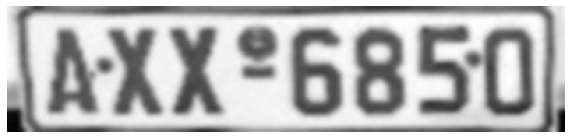

In [16]:
show_image(blurred, cmap='gray')

## 1. Thresholding

### 1.1 Simple Thresholding

In simple thresholding, we manually supply our T threshold value. Any value above this value will be set to `max_val` in a binary thresholding operation or 0 for an inverse binary operation. Here we set `max_val` to 255.

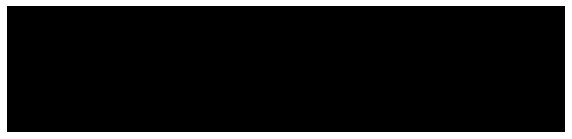

In [17]:
# using normal thresholding (rather than inverse thresholding),
# we can change the last argument in the function to make the coins
# black rather than white.
(T, thresh) = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)
# Threshold Binary
show_image(thresh, cmap = 'gray')

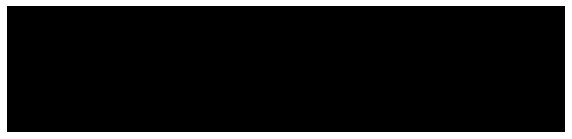

In [18]:
(T, threshInv) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
# Threshold Binary Inverse
show_image(threshInv, cmap = 'gray')

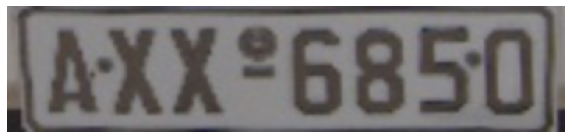

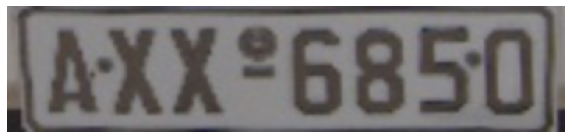

In [19]:
# finally, we can visualize only the masked regions in the image
bitwise_output = cv2.bitwise_and(image, image, mask=threshInv)
show_image(np.flip(image, axis = 2))
show_image(np.flip(bitwise_output, axis = 2))

### 1.2 Otsu's Method
Otsu’s method assumes that our image contains two classes of pixels: the background and the foreground. Furthermore, Otsu’s method makes the assumption that the grayscale histogram of our pixel intensities of our image is bi-modal, which simply means that the histogram is two peaks.

Based on the image's grayscale histogram, Otsu’s method then computes an optimal threshold value T such that the variance between the background and foreground peaks is minimal.

It’s also important to note that Otsu’s method is an example of global thresholding — implying that a single value of T is computed for the entire image. In some cases, having a single value of T for an entire image is perfectly acceptable — but in other cases, this can lead to sub-par results.

Otsu's thresholding value: 105.0


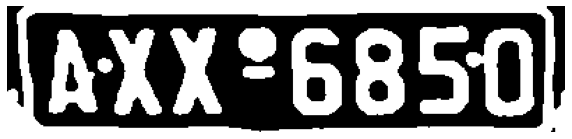

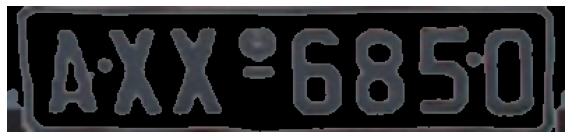

In [20]:
# apply Otsu's automatic thresholding -- Otsu's method automatically
# determines the best threshold value `T` for us
(T, threshInv) = cv2.threshold(blurred, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print("Otsu's thresholding value: {}".format(T))
show_image(threshInv, cmap = 'gray') # same as cv2.imshow("Threshold", threshInv)
 
# finally, we can visualize only the masked regions in the image
bitwise_and = cv2.bitwise_and(image, image, mask=threshInv)
show_image(bitwise_and, cmap = 'gray') # same as cv2.imshow("Output", bitwise_and)

### 1.3 Adaptive Thresholding

Adaptive thresholding considers small neighbors of pixels and then finds an optimal threshold value T for each neighbor. This method allows us to handle cases where there may be dramatic ranges of pixel intensities and the optimal value of T may change for different parts of the image.

However, choosing the size of the pixel neighborhood for local thresholding is absolutely crucial.
The neighborhood must be large enough to cover sufficient background and foreground pixels, otherwise the value of T will be more or less irrelevant.

In [21]:
from skimage.filters import threshold_local

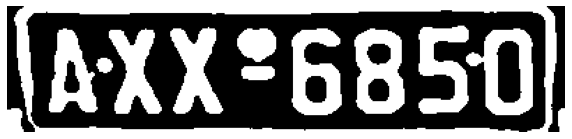

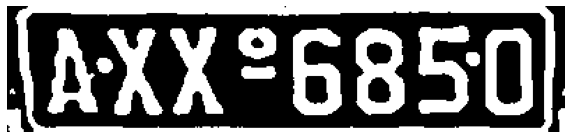

In [22]:
# instead of manually specifying the threshold value, we can use adaptive
# thresholding to examine neighborhoods of pixels and adaptively threshold
# each neighborhood -- in this example, we'll calculate the mean value
# of the neighborhood area of 25 pixels and threshold based on that value;
# finally, our constant C is subtracted from the mean calculation (in this
# case 15)
thresh = cv2.adaptiveThreshold(blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 35, 5)
show_image(thresh, cmap = 'gray') # same as cv2.imshow("OpenCV Mean Thresh", thresh)
 
# personally, I prefer the scikit-image adaptive thresholding, it just
# feels a lot more "Pythonic"
T = threshold_local(blurred, 33, offset=4, method="gaussian")
thresh = (blurred < T).astype("uint8") * 255
show_image(thresh, cmap = 'gray') # cv2.imshow("scikit-image Mean Thresh", thresh)

### EXERCISE: Apply all three types of thresholding to another image - Which one has performs better for that image? Why?

In [43]:
# TODO: Apply the above three thresholding methods to another image. Which has performed better? - You may need to fine tune Hyperparameters

# construct the list of thresholding methods
methods = [
    "Threshold",
    "OtsuMethod",
    "AdapThresholding"
    ]
plt.figure(figsize=(20,10))
#image = np.flip(cv2.imread('../img/coding.png'), axis =2)

image = cv2.imread('../img/test/goldhill.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# loop over the interpolation methods
for i, (name) in enumerate(methods):
    if name == "Threshold":
        (T, thresh) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
        height, width = thresh.shape[:2]
        dim = (height, width)
        result = thresh
    if name == "OtsuMethod":
        (T, thresh) = cv2.threshold(blurred, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        height, width = thresh.shape[:2]
        dim = (height, width)
        result = thresh
    if name == "AdapThresholding":
        thresh = cv2.adaptiveThreshold(blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 35, 5)
        height, width = thresh.shape[:2]
        dim = (height, width)
        result = thresh
    plt.subplot(2,3,i+1),plt.imshow(result, cmap = 'gray')
    plt.title(f'Method: {name}, size: {dim}')
plt.subplot(2,3,4), plt.imshow(image)
plt.title(f'Original - Shape: {image.shape[:2]}')

error: OpenCV(3.4.2) c:\miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<1,-1,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


<Figure size 1440x720 with 0 Axes>

## 2. Image Gradients

### 2.1 Sobel and Scharr Derivatives
The Sobel method uses two kernels for calculating gradients: one for detecting horizontal changes in direction and the other for detecting vertical changes in direction

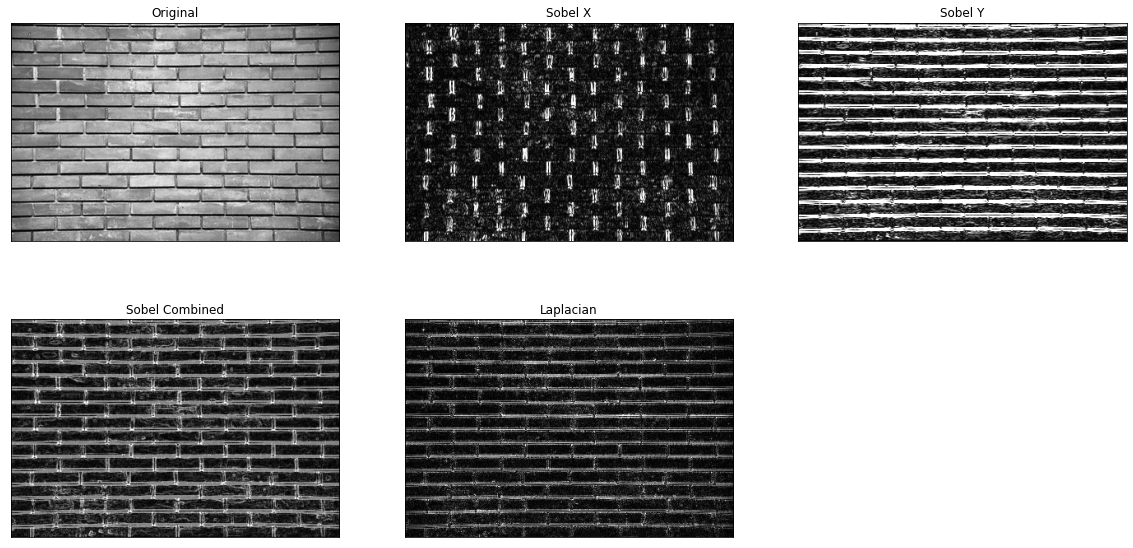

In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../img/bricks.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# compute gradients along the X and Y axis, respectively
sobelx = cv2.Sobel(gray, ddepth = cv2.CV_64F, dx=1, dy=0)
sobely = cv2.Sobel(gray, ddepth = cv2.CV_64F, dx=0, dy=1)

# the gx and gy images are now of the floating point data type
# so we need to take care to convert them back to an unsigned 8-bit
# integer representation so other opencv functions can utilise them
sobelx = cv2.convertScaleAbs(sobelx)
sobely = cv2.convertScaleAbs(sobely)
sobel_combined = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)

# Compute combined gradients using Laplacian Algorithm (and convert floating values to ints)
laplacian = cv2.Laplacian(gray,cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1),plt.imshow(gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,4),plt.imshow(sobel_combined,cmap = 'gray')
plt.title('Sobel Combined'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.show()

### 2.2 Output Datatypes

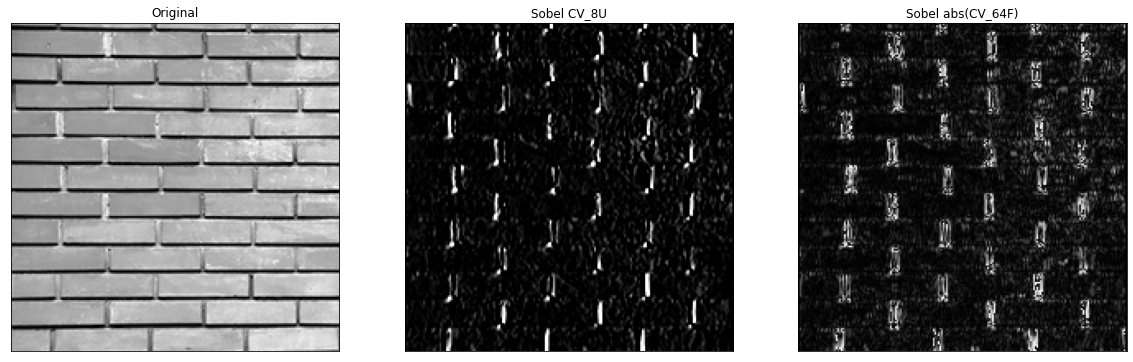

In [26]:
img = cv2.imread('../img/bricks.png',0)[0:200, 0:200]

# Output dtype = cv2.CV_8U
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0)

# Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx8u,cmap = 'gray')
plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobel_8u,cmap = 'gray')
plt.title('Sobel abs(CV_64F)'), plt.xticks([]), plt.yticks([])

plt.show()

### 2.3 Gradient Orientation and Magnitude

In [27]:
img = cv2.imread('../img/bricks.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# compute gradients along the X and Y axis, respectively
gX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
 
# compute the gradient magnitude and orientation respectively
mag = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180

# Printing magnitude and orientation at pixel (100, 100)
print('Magnitude at pixel (100, 100):', mag[100, 100])
print('Orientation at pixel (100, 100):', orientation[100, 100])

Magnitude at pixel (100, 100): 477.84934864452833
Orientation at pixel (100, 100): 95.04245106917091


### 2.4 Detecting Gradient Changes using Orientation

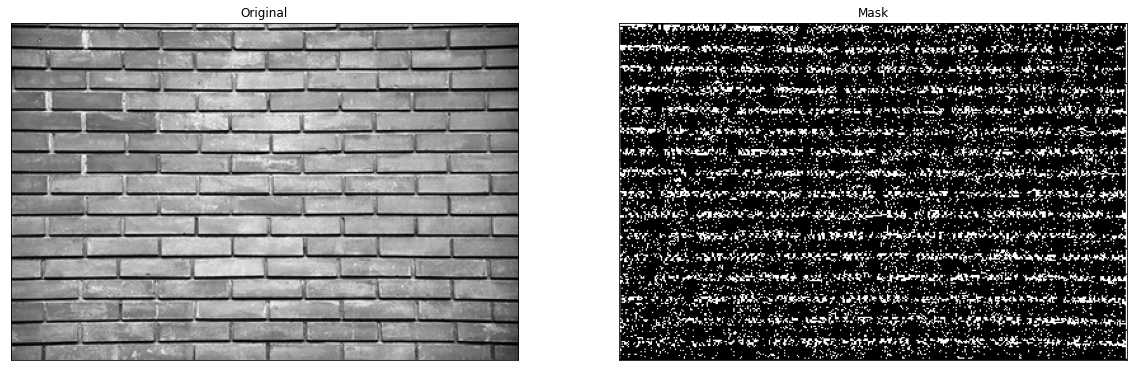

In [28]:
lower_angle = 90
upper_angle = 100

# find all pixels that are within the upper and low angle boundaries
idxs = np.where(orientation >= lower_angle, orientation, -1)
idxs = np.where(orientation <= upper_angle, idxs, -1)
mask = np.zeros(gray.shape, dtype="uint8")
mask[idxs > -1] = 255
 
# show the images
plt.figure(figsize=(20,10))
plt.subplot(1,2,1),plt.imshow(gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(mask,cmap = 'gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.show()

### EXERCISE: Calculating Orientation and Magnitude

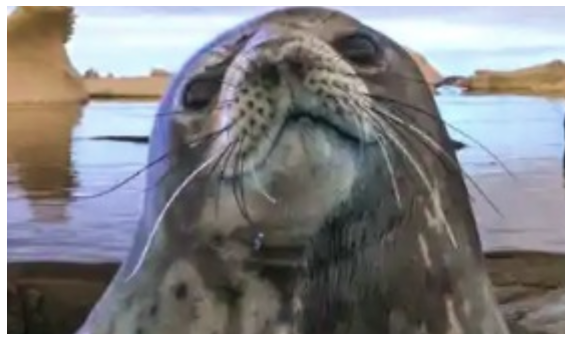

Gradient at pixel (80, 80) has magnitude 4.47213595499958 and orientation 26.565051177078004 degrees


In [29]:
# TODO: Load the seal image and calculate the gradient orientation and magnitude of the image at pixel 100, 100
img = cv2.imread('../img/seal.png')
show_image(img)

import cv2
import numpy as np
image = cv2.imread('../img/seal.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# compute gradients along the X and Y axis, respectively
gX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
# compute the gradient magnitude and orientation respectively
mag = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180
print(f'Gradient at pixel (80, 80) has magnitude {mag[80, 80]} and orientation {orientation[80, 80]} degrees')

In [32]:
# %load ../solutions/gradient_seal.py
import cv2
import numpy as np

image = cv2.imread('../img/seal.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# compute gradients along the X and Y axis, respectively
gX = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
gY = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

# compute the gradient magnitude and orientation respectively
mag = np.sqrt((gX ** 2) + (gY ** 2))
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180

print(f'Gradient at pixel (80, 80) has magnitude {mag[80, 80]} and orientation {orientation[80, 80]} degrees')


Gradient at pixel (80, 80) has magnitude 4.47213595499958 and orientation 26.565051177078004 degrees


## 3. Edge Detection

### 3.1 Canny Edge Detection

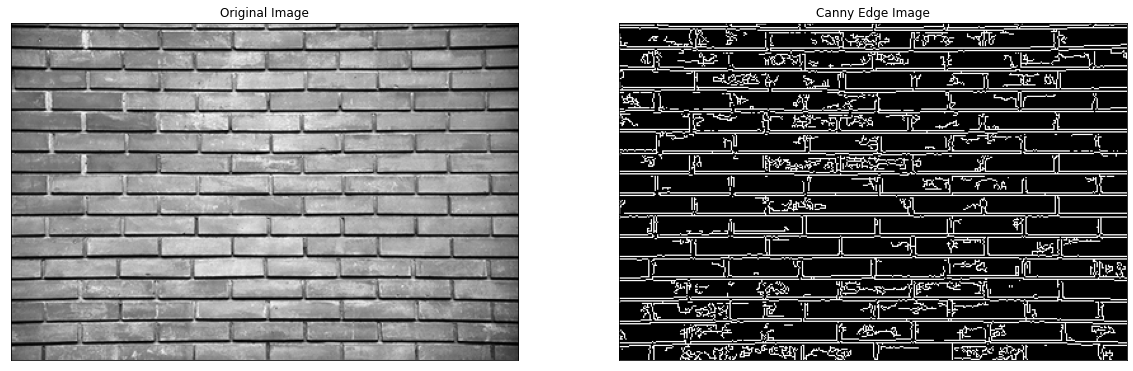

In [33]:
image = cv2.imread("../img/bricks.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 10, 250)

plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Canny Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### 3.2 Tuning Edge Detection Parameters

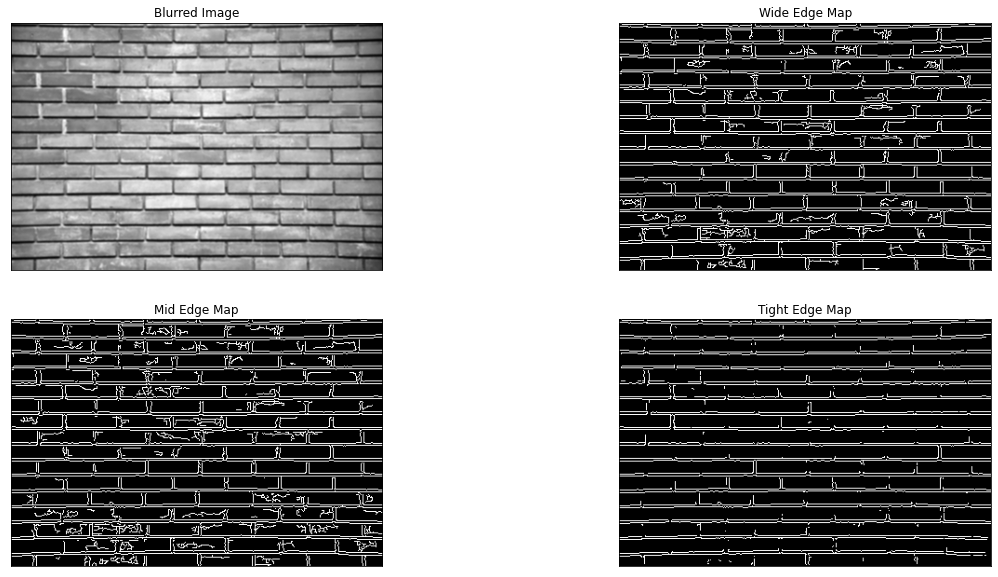

In [34]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('../img/bricks.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# compute a "wide", "mid-range", and "tight" threshold for the edges
wide = cv2.Canny(blurred, 10, 200)
mid = cv2.Canny(blurred, 30, 150)
tight = cv2.Canny(blurred, 240, 250)
 
# show the edge maps
plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(blurred,cmap = 'gray')
plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(wide,cmap = 'gray')
plt.title('Wide Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(mid,cmap = 'gray')
plt.title('Mid Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(tight,cmap = 'gray')
plt.title('Tight Edge Map'), plt.xticks([]), plt.yticks([])
plt.show()

### EXERCISE: Apply Canny Edge detection to the license plate image. Fine tune the upper and lower limit Threshold values. What are these values?

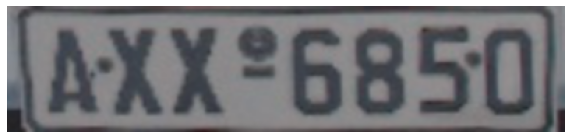

In [35]:
image = cv2.imread('../img/license_plate.png')
show_image(image)

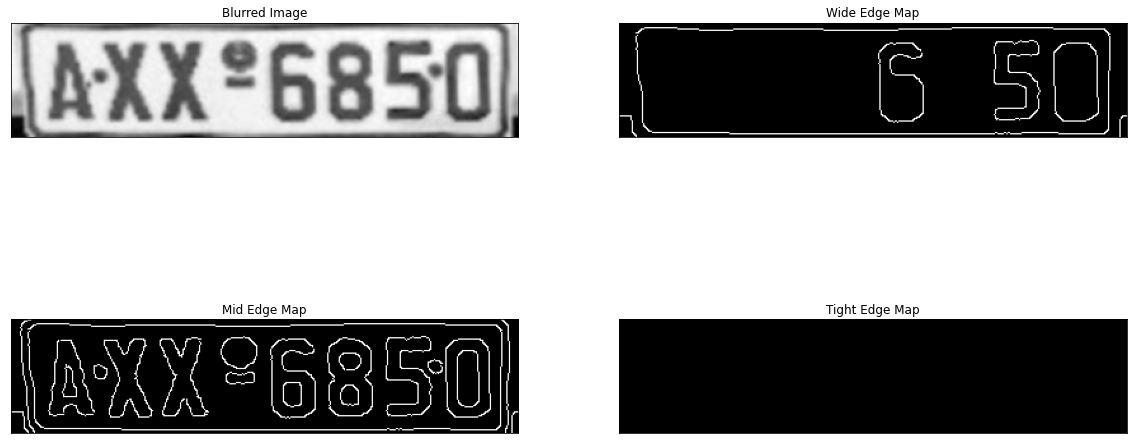

In [36]:
# TODO: Your code below
# %load ../solutions/canny_license_plate.py
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('../img/license_plate.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
# compute a "wide", "mid-range", and "tight" threshold for the edges
wide = cv2.Canny(blurred, 10, 200)
mid = cv2.Canny(blurred, 30, 150)
tight = cv2.Canny(blurred, 240, 250)
# show the edge maps
plt.figure(figsize=(20, 10))
plt.subplot(221), plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(wide, cmap='gray')
plt.title('Wide Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(mid, cmap='gray')
plt.title('Mid Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(tight, cmap='gray')
plt.title('Tight Edge Map'), plt.xticks([]), plt.yticks([])
plt.show()

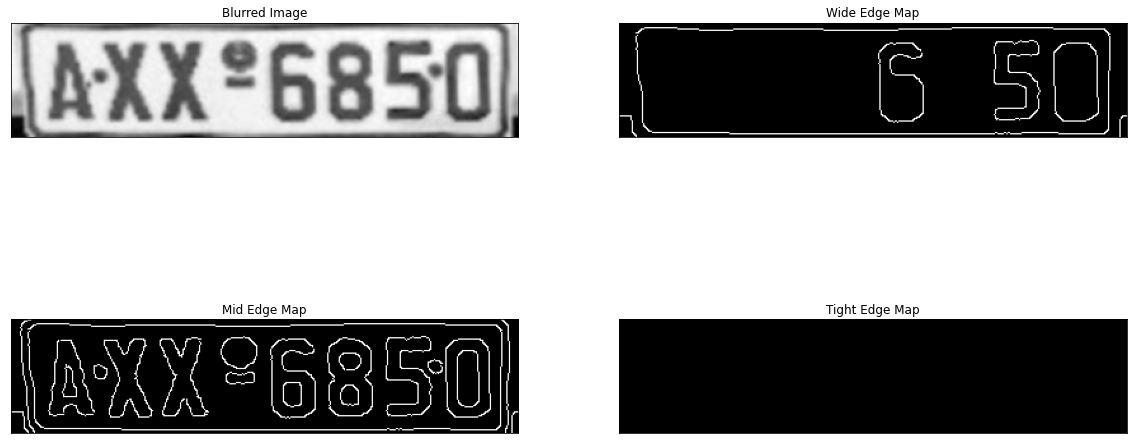

In [37]:
# %load ../solutions/canny_license_plate.py
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('../img/license_plate.png')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# compute a "wide", "mid-range", and "tight" threshold for the edges
wide = cv2.Canny(blurred, 10, 200)
mid = cv2.Canny(blurred, 30, 150)
tight = cv2.Canny(blurred, 240, 250)

# show the edge maps
plt.figure(figsize=(20, 10))
plt.subplot(221), plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(wide, cmap='gray')
plt.title('Wide Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(mid, cmap='gray')
plt.title('Mid Edge Map'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(tight, cmap='gray')
plt.title('Tight Edge Map'), plt.xticks([]), plt.yticks([])
plt.show()


### 3.3 Auto-Tuning Edge Detection Parameters

In [38]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

In [39]:
auto = auto_canny(blurred)

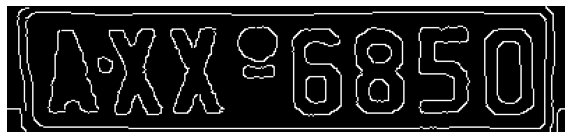

In [40]:
# show the image
show_image(auto, cmap = 'gray')